# Otto Group Product Classification Challenge 🛍

## 1. Problem Definition

> How well can we classify future products into one of the main product categories?

## 2. Data

The data is downloaded from [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview).

Each row corresponds to a single product. There are a total of **93 numerical features**, which **represent counts** of different events. All features have been obfuscated and will not be defined any further.

There are **nine categories** for all products. Each target category represents one of our most important product categories (like fashion, electronics, etc.). The products for the training and testing sets are selected randomly.

### File descriptions
* trainData.csv - the training set
* testData.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

### Data fields
* id - an anonymous id unique to a product
* feat_1, feat_2, ..., feat_93 - the various features of a product
* target - the class of a product

## 3. Evaluation

The evaluation for the competition is **multi-class logarithm loss**. See [Kaggle: Evaluation](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview/evaluation).

_Note_: Scikit-learn provides a utility function: [log_Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).

## 4. Features

There are 93 numerical features, see 2. Data.

## Imports and Data Exploration

In [84]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# Models from Scikit-Learn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, f1_score, roc_curve, plot_roc_curve, log_loss, recall_score

### Load Data & EDA

In [2]:
df = pd.read_csv('../../data/otto/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       61878 non-null  int64 
 1   feat_1   61878 non-null  int64 
 2   feat_2   61878 non-null  int64 
 3   feat_3   61878 non-null  int64 
 4   feat_4   61878 non-null  int64 
 5   feat_5   61878 non-null  int64 
 6   feat_6   61878 non-null  int64 
 7   feat_7   61878 non-null  int64 
 8   feat_8   61878 non-null  int64 
 9   feat_9   61878 non-null  int64 
 10  feat_10  61878 non-null  int64 
 11  feat_11  61878 non-null  int64 
 12  feat_12  61878 non-null  int64 
 13  feat_13  61878 non-null  int64 
 14  feat_14  61878 non-null  int64 
 15  feat_15  61878 non-null  int64 
 16  feat_16  61878 non-null  int64 
 17  feat_17  61878 non-null  int64 
 18  feat_18  61878 non-null  int64 
 19  feat_19  61878 non-null  int64 
 20  feat_20  61878 non-null  int64 
 21  feat_21  61878 non-null  int64 
 22

In [3]:
df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


**Note**: Target value is type object (string)

### Convert Target Column into Category

In [4]:
def convert_into_category(df):
    """
    Converts all non-numerical columns of a Pandas
    DataFrame into a categorical type.
    """
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    return df

In [5]:
convert_into_category(df)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,9


In [6]:
df.target.value_counts()

2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64

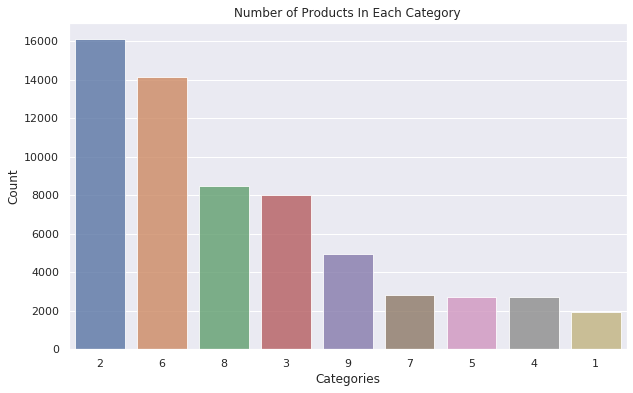

In [7]:
# Plotting a bar chart for the target values
category_count = df.target.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(category_count.index, category_count.values,
            order=category_count.index,
            alpha=0.8)
plt.title('Number of Products In Each Category')
plt.ylabel('Count')
plt.xlabel('Categories', fontdict={'fontsize': 12});

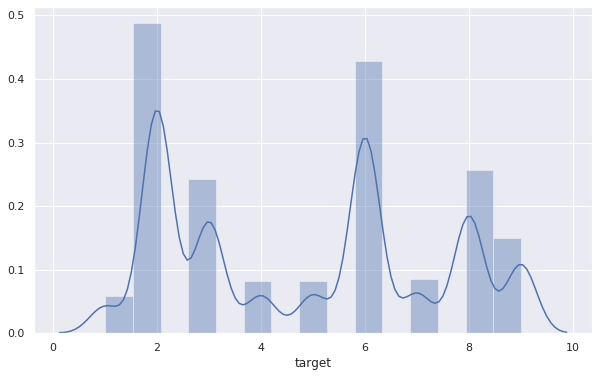

In [8]:
# Visualize distribution

plt.figure(figsize=(10,6))
sns.distplot(df.target, bins=15);

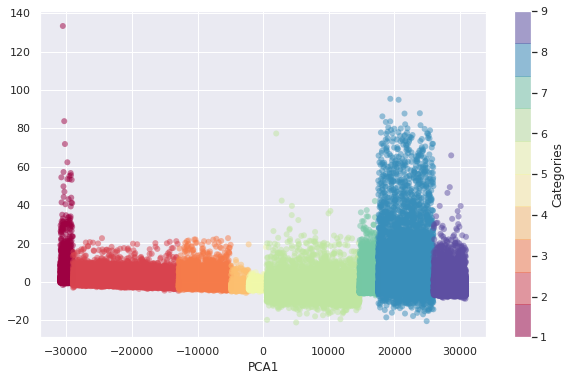

In [9]:
# Visualize dataset with PCA
from sklearn.decomposition import PCA

# instantiate model with 2 dimensions
pca = PCA(2)

# project from 93 to 2 dimensions
projected = pca.fit_transform(df)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.colorbar(label='Categories');

The full data is a 93-dimensional point cloud. These pointr are the projection of each data pointAlong the directions with largest variance.

See [Principal Component Analysis (Data Science Handbook)](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

In [10]:
# Split into features and label

X = df.drop('target', axis=1)
y = df.target

# Split into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

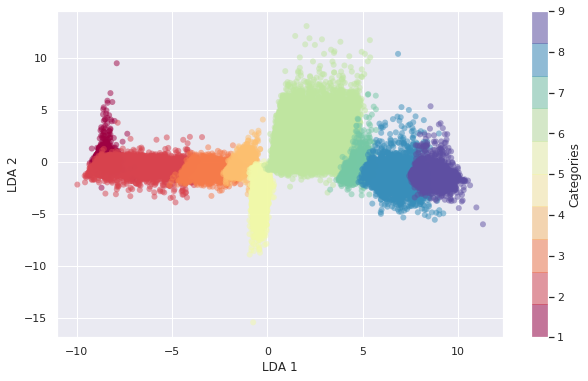

In [11]:
# Visualize dataset with LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# instantiate model with 2 dimensions
lda = LinearDiscriminantAnalysis(n_components=2)

# project from 93 to 2 dimensions
projected = lda.fit_transform(X, y)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.colorbar(label='Categories');

## 5. Data Modelling

### Dimensionality Reduction with PCA

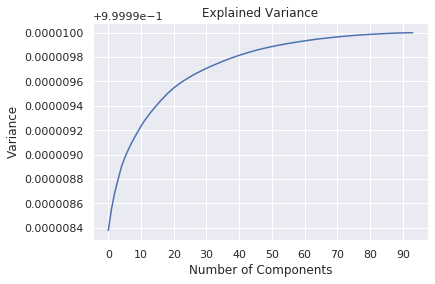

In [12]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 100, step=10))
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Explained Variance');

**Note**: With 80 components, we preserve almost 100% of the total variance of the data.

In [13]:
pca = PCA(n_components=80)
X_pca = pca.fit_transform(X)
X_pca.shape

(61878, 80)

In [14]:
# Create new test and training set from reduced dataset
np.random.seed(42)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2)

### Naive Bayes

In [15]:
# Instantiate Naive Bayes and fit
naive_bayes_pca_clf = GaussianNB().fit(X_train_pca, y_train_pca)

In [16]:
def average_score_on_cross_val_classification(clf, X, y):
    """
    Evaluates a given model/estimator using cross-validation (5 folds)
    and returns a dict containing the average (mean) scores
    for classification models

    clf: scikit-learn classification
    X: features (no labels)
    y: labels
    """
    # Create a dictionary of scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score, average='macro'),
               'recall': make_scorer(recall_score, average='macro'),
               'f1': make_scorer(f1_score, average='macro'),
               'log loss': 'neg_log_loss'}
    
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring)
    
    # return the average scores for each metric
    return {metric: round(np.mean(scores), 2) for metric, scores in scores_dict.items()}


In [17]:
naive_bayes_pca_metrics = average_score_on_cross_val_classification(naive_bayes_pca_clf, X, y)
naive_bayes_pca_metrics

{'fit_time': 0.09,
 'score_time': 0.13,
 'test_accuracy': 0.81,
 'test_precision': 0.84,
 'test_recall': 0.79,
 'test_f1': 0.79,
 'test_log loss': -2.22}

In [18]:
y_preds_naive_bayes_pca = naive_bayes_pca_clf.predict(X_test_pca)
y_preds_naive_bayes_proba_pca = naive_bayes_pca_clf.predict_proba(X_test_pca)

In [19]:
log_loss(y_test_pca, y_preds_naive_bayes_proba_pca)

1.7782521642198441

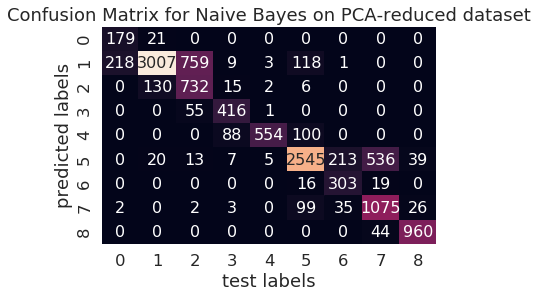

In [20]:
# Confusion Matrix
naive_bayes_pca_conf_mat = confusion_matrix(y_test_pca, y_preds_naive_bayes_pca)

sns.set(font_scale=1.5)
sns.heatmap(naive_bayes_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Naive Bayes on PCA-reduced dataset');

### Random Forest Classification

In [34]:
# Initialize and fit Random Forest Classifier
rf_pca_clf = RandomForestClassifier().fit(X_train_pca, y_train_pca)

In [29]:
# Show scores
rf_pca_metrics = average_score_on_cross_val_classification(rf_pca_clf, X, y)
rf_pca_metrics

{'fit_time': 7.17,
 'score_time': 0.34,
 'test_accuracy': 0.91,
 'test_precision': 0.92,
 'test_recall': 0.93,
 'test_f1': 0.91,
 'test_log loss': -0.36}

In [30]:
# Create predictions
y_preds_rf_pca = rf_pca_clf.predict(X_test_pca)
y_preds_rf_proba_pca = rf_pca_clf.predict_proba(X_test_pca)

In [33]:
log_loss(y_test_pca, y_preds_rf_proba_pca)

0.15143361048307982

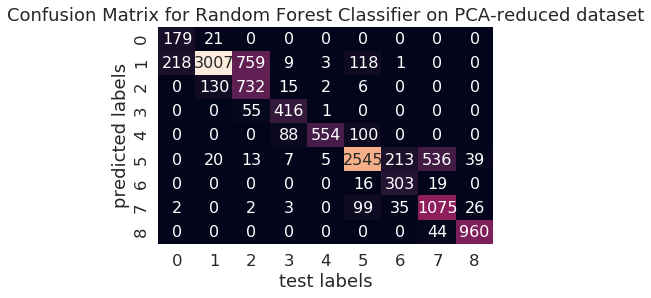

In [86]:
# Confusion Matrix
naive_bayes_pca_conf_mat = confusion_matrix(y_test_pca, y_preds_naive_bayes_pca)

sns.set(font_scale=1.5)
sns.heatmap(naive_bayes_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Random Forest Classifier on PCA-reduced dataset');

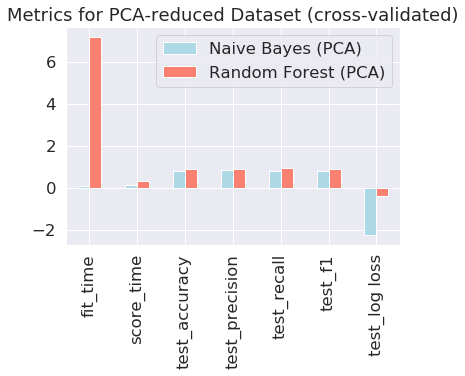

In [87]:
# Visualize cross-validated metrics
compare_metrics_df = pd.DataFrame({'Naive Bayes (PCA)': naive_bayes_pca_metrics,
                                   'Random Forest (PCA)': rf_pca_metrics},
                                  index=naive_bayes_pca_metrics.keys())

compare_metrics_df.plot(title='Metrics for PCA-reduced Dataset (cross-validated)',
                        color=['lightblue', 'salmon'],
                        kind='bar');